# Cours 9: Introduction à Keras

Arthur Llau, arthur@flowlity.com

**Plan** : 
- Benchmark
- Définition de l'architecture d'un modèle
- Layers, Activation & Optimizer
- Callbacks
- NLP tricks
- Vision tricks


## I - Introduction - Benchmark : classification & régréssion

In [1]:
import warnings
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.datasets import make_classification,make_regression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
X,y = make_classification(n_samples = 100000, n_features = 100, shuffle = True, random_state = 1234)
X_tr,X_te,y_tr,y_te = train_test_split(X, y, random_state = 2019) 

In [3]:
X,y = make_regression(n_samples = 100000, n_features = 100, shuffle = True, random_state = 1234, noise = True)
S_tr,S_te,s_tr,s_te = train_test_split(X, y, random_state = 2019) 

**1.1** Evaluer une régréssion logistique avec la métrique AUC sur le jeu de test correspondant.

In [4]:
model1 = LogisticRegression()
model1.fit(X_tr,y_tr)
print ('Logistic Regression AUC : {}'.format(roc_auc_score(y_te, model1.predict(X_te))))

Logistic Regression AUC : 0.8846408666970337


**1.2** Evaluer une régréssion linéaire avec la métrique MAE sur le jeu de test correspondant.

In [5]:
model1 = LinearRegression()
model1.fit(S_tr,s_tr)
print ('Linear Regression MAE : {}'.format(mean_absolute_error(s_te, model1.predict(S_te))))

Linear Regression MAE : 0.8011711587804731


## Que trouve-t'on dans Keras ?


Keras est une API de deep learning, interfacable avec plusieurs framework comme Tensorflow, CNTK, Theano ou MxNet

Points positifs :
-  Facilité de prise en main, user-friendly, ressemble à sklearn
-  Modulaire : on construit le graphe couche par couche ou comme un graphe 
-  Permet de mettre en place rapidement des tests
-  Grosse communauté donc plein de papiers implémentés
-  Plus rapide que torch en prédiction

## II - Définir l'architecture d'un modèle

![](networkx.png)

Il existe deux méthodes pour définir un modèle :
- Sequential : couche par couche
- API : architecture arbitraire


In [6]:
import os
os.environ["KERAS_BACKEND"] = "torch"

from keras import layers
from keras import models

## Sequential, la plus simple
#input_shape taille d'entrée (nombre de features dans le cas de données tabulaires),
#si image (longueur,largeur,nb_couche)
model = models.Sequential()
model.add(layers.Dense(4, input_shape = (100,)))
model.add(layers.Dense(1, activation= 'sigmoid'))


Using TensorFlow backend.


In [7]:

#API qui permet de concatener des layers
input_matrix = layers.Input((100,))
x = layers.Dense(4)(input_matrix)
output = layers.Dense(1)(x)
model = models.Model(input_matrix, output)

![exemple](model.png)

In [8]:
object_a = layers.Input(shape=(280, 256))
object_b = layers.Input(shape=(280, 256))

shared_layer = layers.LSTM(64)
#On construit deux layers indépendant
layer_a = shared_layer(object_a)
layer_b = shared_layer(object_b)
#On les concatene
merged_vector = layers.concatenate([layer_a, layer_b], axis=-1)
#On ajoute l'output
predictions = layers.Dense(1, activation='sigmoid')(merged_vector)

model_concat = models.Model(inputs=[object_a, object_b], outputs=predictions)


Une fois le modèle construit, il faut compiler. C'est-à-dire lui spécifier la fonction objectif (loss) et l'algorithme d'optimisation permettant de mettre à jour les poids du réseau. (optimizer)



In [9]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['acc'])


On peut afficher un résumé de l'architecture avec la commande suivante :

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________


*Pourquoi a-t'on 404 paramètres dans la couche d'entrée ?*

On dispose  de 4 neurones, et 100 features, donc le nombre de paramètres est égale à nb neurones * nb features + nb neurones (biais)

On peut sauvegarder l'architecture comme une image grâce à plot_model : 

In [11]:

from keras.utils import plot_model
plot_model(model, to_file='model_init.png', show_shapes=True, show_layer_names=True)

![](model_init.png)

Il ne reste plus qu'à lui faire apprendre des données.

In [12]:
%%capture
history = model.fit(X_tr,y_tr, epochs = 100, batch_size = 10000)
# Batch = nombre d'échantillons que l'on envoie dans le réseau à chaque itération
# Epoch = nombre de forward et backward totaux que l'on souhaite réaliser

On peut récupérer les valeurs de loss et de la métrique durant l'évaluation

Text(0, 0.5, 'metric')

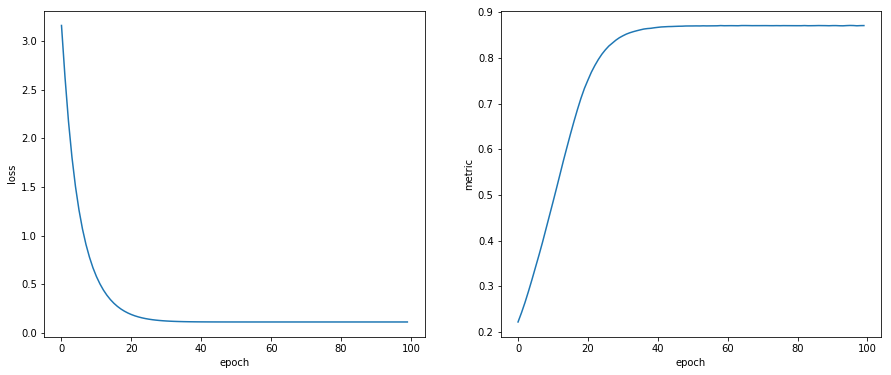

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range(100),history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(range(100),history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('metric')


Pour **prédire**, rien de plus simple. model.predict(X)

## III - Layers, Activations & Optimizer

In [14]:
from keras.layers import *
from keras.models import Sequential


Pour des données tabulaires il y a principalement trois layers importants : Dense, Dropout, Activation.

In [15]:
#Dense : Fully connected layer
Dense(units = 30, activation=None, use_bias=True, kernel_initializer='glorot_uniform')
print("""units : nombre de cellules

activation : fonction d'activation""")

units : nombre de cellules

activation : fonction d'activation


In [16]:
#Dropout : Regularization en faisant sauter des neurones pendant l'apprentissage
Dropout(rate = 0.3, seed=None)
print("""rate : taux de dropout""")

rate : taux de dropout


In [17]:
model = Sequential()

#La couche d'activation est équivalente à l'option activation dans une couche
model.add(Dense(64, activation = 'relu'))
# équivalent à 
model.add(Dense(64))
model.add(Activation(activation='relu'))

On trouve quatre activations principales :
- linear : le signal n'est pas transformé
- tanh : $\frac{e^x−1}{e^x+1}$retourne une valeur entre -1 et 1  
- sigmoid :  $ f(x)=\frac{1}{1 + e^{- x}}$, retourne une valeur entre 0 et 1
- relu : $max(0,x)$, on garde uniquement ce qui nous intéresse 

La denière couche du réseau est celle qui nous donne l'output désiré. Sa dimension, ainsi que son activation doivent être choisi pour répondre à la problématique voulu.

**Classification binaire** :

- nombre de neurones : 1
- activation : sigmoid $ f(x)=\frac{1}{1 + e^{- x}}$
- loss : binary_crossentropy



**Classification multiclasses** :
    
- nombre de neurones : nombre de classes
- activation : softmax
- loss : categorical_crossentropy

    
    

**Régréssion** :
    
- nombre de neurones : 1
- activation : linéaire
- loss : toute loss différentiable

    
    

Le choix de l'algorithme d'optimisation est toujours une grande question. L'utilisation de l'algorithme peut être réalisé de deux façons.

In [18]:
from keras.optimizers import SGD
#Avec les paramètres par défault
model.compile(loss = 'mean_squared_error', optimizer='sgd')

## Ou bien pour pouvoir customiser l'algorithme
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

Voici un rapide récapitulatif des principaux algorithmes d'optimisation  :
-  SGD, le plus classique, fluctue autour du minimum
-  RMSprop, bon choix pour les réseaux récurrent
-  Adam, efficace dans la majorité des cas (https://arxiv.org/abs/1412.6980v8)


**Question 1** : Dans le cas de la classification binaire construire un modèle permettant d'atteindre la valeur de la régréssion logistique, en l'évaluant sur le jeu de test correspondant. Et afficher les valeurs de loss et de métrique.

In [19]:
from keras.models import *
from keras.layers import *


In [20]:
BS = 10000
EPOCHS = 100

In [21]:
model = Sequential()
model.add(Dense(100, input_shape = (X_tr.shape[1],)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
history = model.fit(X_tr, y_tr, batch_size = BS, epochs = EPOCHS)

Epoch 1/100
75000/75000 [==============================] - 0s 4us/step - loss: 0.7799 - acc: 0.4998
Epoch 2/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.6670 - acc: 0.5639
Epoch 3/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.6058 - acc: 0.7387
Epoch 4/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.5502 - acc: 0.8053
Epoch 5/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.4822 - acc: 0.8487
Epoch 6/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.4163 - acc: 0.8660
Epoch 7/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.3642 - acc: 0.8732
Epoch 8/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.3281 - acc: 0.8795
Epoch 9/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.3054 - acc: 0.8835
Epoch 10/100
75000/75000 [==============================] - 0s 1us/step - loss: 0.2912 - acc: 0.8868

Text(0, 0.5, 'metric')

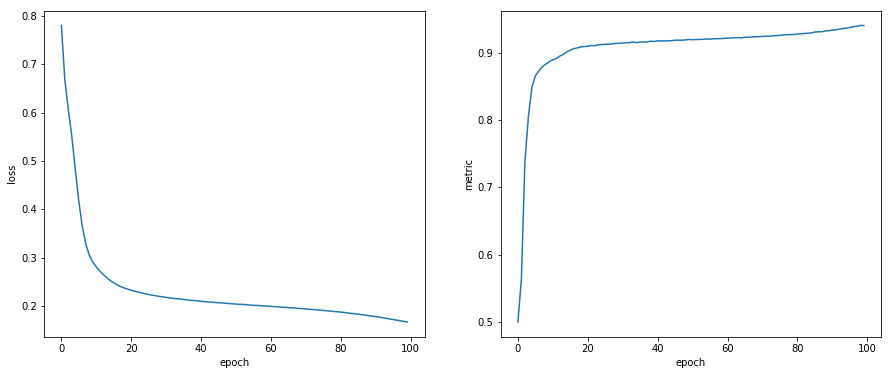

In [23]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range(100),history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(range(100),history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('metric')


In [24]:
preds = model.predict(X_te)
print ('Model performance {}'.format(roc_auc_score(y_te, preds)))

Model performance 0.9743885761094649


**Question 2** : Dans le cas de la régréssion construire un modèle permettant d'atteindre la valeur de la régréssion linéaire, en l'évaluant sur le jeu de test correspondant. Et faites une figure des valeurs de loss et de métrique.

In [25]:
from keras import backend as K
K.clear_session()

In [26]:
model2 = Sequential()
model2.add(Dense(100, input_shape = (S_tr.shape[1],)))
model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(1, activation = 'relu'))
model2.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae'])

In [27]:
BS = 100000
EPOCHS = 1000
history = model2.fit(S_tr, s_tr, batch_size = BS, epochs = EPOCHS)

Epoch 1/1000
75000/75000 [==============================] - 0s 3us/step - loss: 176.1094 - mean_absolute_error: 176.1094
Epoch 2/1000
75000/75000 [==============================] - 0s 1us/step - loss: 176.0957 - mean_absolute_error: 176.0957
Epoch 3/1000
75000/75000 [==============================] - 0s 1us/step - loss: 176.0803 - mean_absolute_error: 176.0803
Epoch 4/1000
75000/75000 [==============================] - 0s 1us/step - loss: 176.0642 - mean_absolute_error: 176.0642
Epoch 5/1000
75000/75000 [==============================] - 0s 1us/step - loss: 176.0474 - mean_absolute_error: 176.0474
Epoch 6/1000
75000/75000 [==============================] - 0s 1us/step - loss: 176.0299 - mean_absolute_error: 176.0299
Epoch 7/1000
75000/75000 [==============================] - 0s 1us/step - loss: 176.0114 - mean_absolute_error: 176.0114
Epoch 8/1000
75000/75000 [==============================] - 0s 1us/step - loss: 175.9917 - mean_absolute_error: 175.9917
Epoch 9/1000
75000/75000 [======

In [28]:
preds = model2.predict(S_te)

In [29]:
mean_absolute_error(s_te,preds)

88.20210439498709

Text(0, 0.5, 'metric')

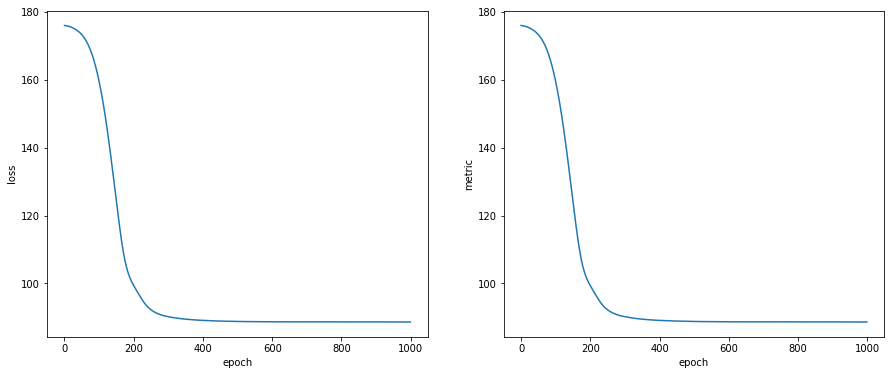

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range(EPOCHS),history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(range(EPOCHS),history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.ylabel('metric')


Peut-on affirmer que nos modèles obtiennent réellement ces scores ?

Absolument pas, on ne les valide pas !
Il y a alors deux manière de rajouter un jeu de validation.

In [31]:
history = model2.fit(S_tr, s_tr, validation_split = 0.2, batch_size = 1000, epochs = 1) # Split aléatoire
history = model2.fit(S_tr, s_tr, validation_data=(S_te,s_te), batch_size = 1000, epochs = 1)

Train on 60000 samples, validate on 15000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 3us/step - loss: 89.2933 - mean_absolute_error: 89.2933 - val_loss: 88.4062 - val_mean_absolute_error: 88.4062
Train on 75000 samples, validate on 25000 samples
Epoch 1/1
75000/75000 [==============================] - 0s 2us/step - loss: 88.9381 - mean_absolute_error: 88.9381 - val_loss: 88.4082 - val_mean_absolute_error: 88.4082


N'avons nous pas oublier quelque chose avant de faire nos modèles ? 


Normaliser les données ! Avec des scalings de différents type par exemple !

### IV. Callbacks

Les callbacks permettent de réaliser des opérations, comme sauver les poids du réseaux, ou utilier un Cycling LR finder.

In [32]:
from keras.callbacks import *

checkpoint  = ModelCheckpoint('weights.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


In [33]:
history = model2.fit(S_tr, s_tr, validation_data=(S_te,s_te), batch_size = 1000, epochs = 10, callbacks=[checkpoint, earlystop, reduce_lr])

Train on 75000 samples, validate on 25000 samples
Epoch 1/10
75000/75000 [==============================] - 0s 2us/step - loss: 88.8715 - mean_absolute_error: 88.8715 - val_loss: 88.3656 - val_mean_absolute_error: 88.3656

Epoch 00001: saving model to weights.h5
Epoch 2/10
75000/75000 [==============================] - 0s 2us/step - loss: 88.8272 - mean_absolute_error: 88.8272 - val_loss: 88.3601 - val_mean_absolute_error: 88.3601

Epoch 00002: saving model to weights.h5
Epoch 3/10
75000/75000 [==============================] - 0s 2us/step - loss: 88.8123 - mean_absolute_error: 88.8123 - val_loss: 88.3741 - val_mean_absolute_error: 88.3741

Epoch 00003: saving model to weights.h5
Epoch 00003: early stopping


## V. NLP & RNN


Layers utiles pour les RNN : LSTM & GRU (voir cours d'E. Scornet)

In [11]:
#couche d'embedding permettant de vectorizer un ensemble de tokens
#Renvoie des entiers positif comme un vecteur dense, ce sont rien de plus que poids mis à jour lors des backprop
Embedding(input_dim = 300, output_dim = 10)
print('input_dim: nombre de mots uniques', "\nouput_dim : taille de l'embedding", "\ninput_lenght :taille maximale d\'une phrase")

input_dim: nombre de mots uniques 
ouput_dim : taille de l'embedding 
input_lenght :taille maximale d'une phrase


In [34]:
#GRU
GRU(units = 50, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False)
print("return_sequence : retourner le dernier élement de la séquence ou la séquence entière")

return_sequence : retourner le dernier élement de la séquence ou la séquence entière


In [35]:
#GRU
LSTM(units = 50, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False)
print("return_sequence : retourner le dernier élement de la séquence ou la séquence entière")

return_sequence : retourner le dernier élement de la séquence ou la séquence entière


In [36]:
#Faster si cuda disponible
CuDNNGRU(units = 50)
CuDNNLSTM(units = 50)

In [37]:
#Flatten : matrice to vector
Flatten()

In [38]:
#BatchNormalization : normalization by each batch to set the feature map mean close to 0
BatchNormalization()

**Comment devons nous transformer des données textuelles ?**

On doit les tokenizer puis les utiliser comme on le souhaite.

In [39]:
from keras.preprocessing.text import text_to_word_sequence
# define the document
text = 'Il fait beau et chaud.'
# tokenize the document
result = text_to_word_sequence(text)
print(result)

['il', 'fait', 'beau', 'et', 'chaud']


In [7]:
#Et pour directement transformer un corpus
from keras.preprocessing.text import Tokenizer
sentences_train = ['il fait beau et chaud','Paris est une belle ville', 'Paris est beau']

tokenizer = Tokenizer(num_words = 5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
#nombre maximum de mots
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
print(X_train) # Que se passe-t'il ?
print(tokenizer.word_index)

[[4, 5, 1, 6, 7], [2, 3, 8, 9, 10], [2, 3, 1]]
{'beau': 1, 'paris': 2, 'est': 3, 'il': 4, 'fait': 5, 'et': 6, 'chaud': 7, 'une': 8, 'belle': 9, 'ville': 10}


In [41]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train)
print(X_train) # Que se passe-t'il ?

[[4 5 1 6 7]
 [0 0 2 3 8]
 [0 0 2 3 1]]


La couche d'input change pour être un embedding, c'est-à-dire une couche de vectorization permettant d'utiliser des données textuelles.


Word embedding: technique permettant de représenter chaque mot d'un dictionnaire par un vecteur de nombres réels.

2 phrases:
- "Hope to see you soon"
- "Nice to see you again"
On assigne un entier unique à chaque mot, dans l'ordre d'apparition.
- [0, 1, 2, 3, 4]
- [5, 1, 2, 3, 6]

Si on veut entrainer notre reseau sur cette première couche il faut alors spécifier:
__Embedding(7, 2, input_length=5)__
7 correspond au nombre de token distincts (vocab size), 2 indique la dimension de l'embedding, et l'input_length la longueur de chaque sequence.


In [42]:
model = Sequential()
vocab_size =len(tokenizer.word_index) + 1 #l'index 0 est utilisé par keras, on ne peut pas l'utiliser
model.add(Embedding(vocab_size, 16))
model.add(LSTM(32))
model.add(Dense(1))

## VI - Exercices

In [1]:
import pandas as pd

from keras.layers import *
from keras.models import *
from keras.optimizers import *

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**Exercice 1** : Avec les données des prix des maisons, construire un nnet permettant de résoudre le problème de régréssion. Evaluer les performances avec la rmse. Tester plusieurs architectures, que constatez-vous ? Comparer les performances avec un autre modèle.

In [44]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [45]:
y_train = train.SalePrice
y_test = test.SalePrice

train.drop(['Id','SalePrice'], axis = 1, inplace = True)
test.drop(['Id','SalePrice'], axis = 1, inplace = True)

In [46]:
for c in train.select_dtypes(object):
    
    train[c] = train[c].fillna('__NC__')
    test[c] = test[c].fillna('__NC__')
    
    enc = LabelEncoder()
    enc.fit(list(train[c])+ list(test[c]))
    train[c] = enc.transform(train[c])
    test[c] = enc.transform(test[c])

train.fillna(-9000, inplace = True)
test.fillna(-9000, inplace = True)

In [47]:
ss = StandardScaler()
ss.fit(list(train.values)+list(test.values))
train = ss.transform(train)
test = ss.transform(test)

In [48]:
#Je définis la métrique pour être utilisable avec Keras
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [49]:
model1 = Sequential()
model1.add(Dense(train.shape[1], input_shape = (train.shape[1],)))
model1.add(Dense(train.shape[1]//2))
model1.add(Dense(1))
model1.compile(loss = 'mean_squared_error', optimizer = 'adadelta', metrics=[root_mean_squared_error])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 79)                6320      
_________________________________________________________________
dense_6 (Dense)              (None, 39)                3120      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 40        
Total params: 9,480
Trainable params: 9,480
Non-trainable params: 0
_________________________________________________________________


In [50]:
from keras.callbacks import *

EPOCHS = 1000
BS = 1000

checkpoint  = ModelCheckpoint('weights.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=50, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


history = model1.fit(train,y_train, validation_data=(test,y_test), batch_size = BS, epochs = EPOCHS, callbacks=[checkpoint, earlystop, reduce_lr])

Train on 1022 samples, validate on 438 samples
Epoch 1/1000
1022/1022 [==============================] - 0s 181us/step - loss: 40346969025.8787 - root_mean_squared_error: 183237.3236 - val_loss: 35987640320.0000 - val_root_mean_squared_error: 175516.8906

Epoch 00001: saving model to weights.h5
Epoch 2/1000
1022/1022 [==============================] - 0s 6us/step - loss: 40346826178.8806 - root_mean_squared_error: 183237.2548 - val_loss: 35987505152.0000 - val_root_mean_squared_error: 175516.8906

Epoch 00002: saving model to weights.h5
Epoch 3/1000
1022/1022 [==============================] - 0s 5us/step - loss: 40346639229.7456 - root_mean_squared_error: 183237.1787 - val_loss: 35987378176.0000 - val_root_mean_squared_error: 175516.8906

Epoch 00003: saving model to weights.h5
Epoch 4/1000
1022/1022 [==============================] - 0s 6us/step - loss: 40346438726.1370 - root_mean_squared_error: 183237.0342 - val_loss: 35987148800.0000 - val_root_mean_squared_error: 175516.9375

Epo

Text(0, 0.5, 'metric')

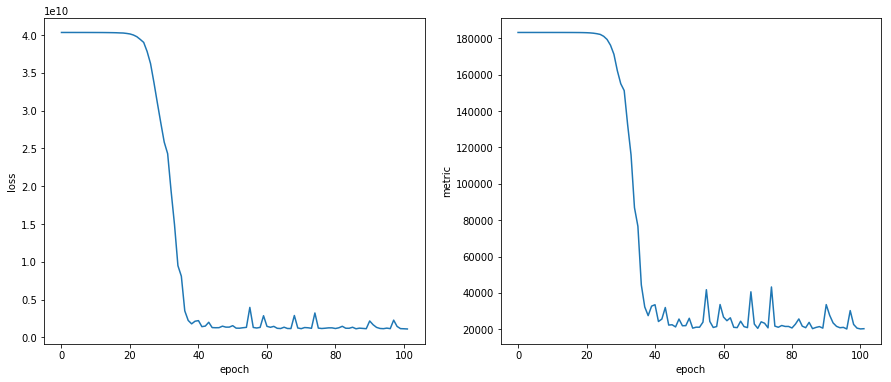

In [51]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range(len(history.epoch)),history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(range(len(history.epoch)),history.history['root_mean_squared_error'])
plt.xlabel('epoch')
plt.ylabel('metric')


In [52]:
print('NNet1 performance : {}'.format(np.sqrt(mean_squared_error(y_test, model1.predict(test)))))


NNet1 performance : 26370.373165003526


In [53]:
from lightgbm import LGBMRegressor
model2 = LGBMRegressor(metric = 'rmse', n_estimators=1000)
model2.fit(train,y_train, eval_set = [(test,y_test)], early_stopping_rounds=20, verbose=20)

Training until validation scores don't improve for 20 rounds.
[20]	valid_0's rmse: 27885.2
[40]	valid_0's rmse: 23385
[60]	valid_0's rmse: 23415.9
Early stopping, best iteration is:
[58]	valid_0's rmse: 23339.3


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       metric='rmse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

**Exercice 2** : A partir des données du cours prédécédent, construire un RNN permettant de résoudre le problème de classification. N'oubliez pas de séparer vos données en train et test pour évaluer vos performances. Essayez de construire deux modèles ayant soit un FE différent soit une architecture différente. Affichez la métrique et la loss. 

In [54]:
data = pd.read_csv('data.csv')
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [55]:
X = data.text; y = data.author

#Ne pas oublié de transformer les targets
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_tr,X_va,y_tr,y_va = train_test_split(X.values,y, test_size = 0.2, random_state = 42)

In [56]:
# Particularité des problèmes de multiclasses et des nnet, on veut des target binarisées 

from keras.utils import to_categorical
y_tr = to_categorical(y_tr)
y_va = to_categorical(y_va)
print(y_tr)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Premier modèle : CountVectorizer

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = 3, max_features = 2000, stop_words = 'english', ngram_range = (1,3))
cv.fit(list(X_tr)+list(X_va))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=3,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [58]:
train_bag = cv.transform(X_tr)
val_bag = cv.transform(X_va)

In [59]:
model = Sequential()
model.add(Dense(256, input_shape = (train_bag.shape[1],)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(3, activation='softmax')) #On veut les probas des trois classes en sortie
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

In [60]:

checkpoint  = ModelCheckpoint('weights.h5', monitor='val_acc', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.01, patience=15, verbose=1, mode='auto', min_delta=0.00001, cooldown=0, min_lr=0)

BS = 1000
EPOCHS = 100
history = model.fit(train_bag,y_tr , validation_data = (val_bag, y_va), batch_size = BS, epochs = EPOCHS, callbacks=[checkpoint,earlystop, reduce_lr])

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 0s 24us/step - loss: 0.9952 - acc: 0.5569 - val_loss: 0.8211 - val_acc: 0.6908

Epoch 00001: val_acc improved from -inf to 0.69076, saving model to weights.h5
Epoch 2/100
15663/15663 [==============================] - 0s 10us/step - loss: 0.6471 - acc: 0.7536 - val_loss: 0.6323 - val_acc: 0.7413

Epoch 00002: val_acc improved from 0.69076 to 0.74132, saving model to weights.h5
Epoch 3/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.5009 - acc: 0.7921 - val_loss: 0.6601 - val_acc: 0.7308

Epoch 00003: val_acc did not improve from 0.74132
Epoch 4/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4494 - acc: 0.8150 - val_loss: 0.6790 - val_acc: 0.7240

Epoch 00004: val_acc did not improve from 0.74132
Epoch 5/100
15663/15663 [==============================] - 0s 11us/step - loss: 0.4243 - acc: 0.8266 - val_loss: 0.7015 - val_acc: 0.7

Text(0, 0.5, 'metric')

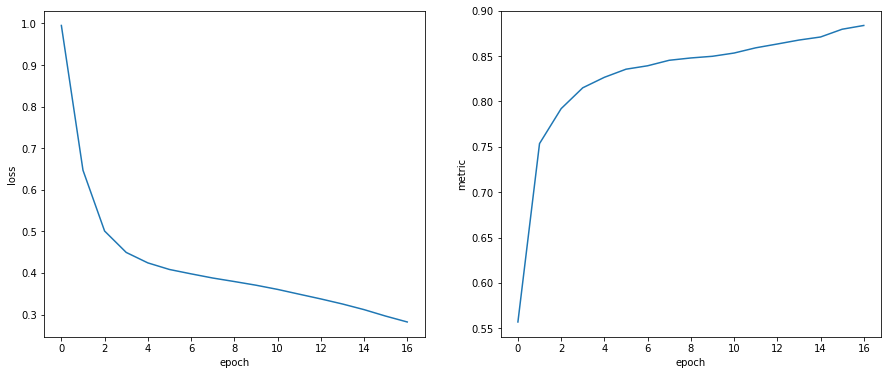

In [62]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range(len(history.epoch)),history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(range(len(history.epoch)),history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('metric')


### Second modèle : LSTM

In [63]:
#On tokenize
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(list(X_tr)+list(X_va))

X_tr = tokenizer.texts_to_sequences(X_tr)
X_va = tokenizer.texts_to_sequences(X_va)
print(X_tr[0])

[13, 85, 31, 1198, 2, 54, 2945, 7, 26, 560]


In [64]:
from keras.preprocessing.sequence import pad_sequences
max_len = 70
X_tr = pad_sequences(X_tr, maxlen = max_len)
X_va = pad_sequences(X_va, maxlen = max_len)


In [65]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1,
                     300,
                     input_length=max_len,
                     trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [66]:

checkpoint  = ModelCheckpoint('weights.h5', monitor='val_acc', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=50, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.01, patience=10, verbose=1, mode='auto', min_delta=0.00001, cooldown=0, min_lr=0)

history = model.fit(X_tr,y_tr, validation_data = (X_va, y_va), batch_size = 1000, epochs = 100, callbacks=[checkpoint,earlystop, reduce_lr])

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 5s 317us/step - loss: 1.0849 - acc: 0.3999 - val_loss: 1.0771 - val_acc: 0.4009

Epoch 00001: val_acc improved from -inf to 0.40092, saving model to weights.h5
Epoch 2/100
15663/15663 [==============================] - 4s 248us/step - loss: 1.0661 - acc: 0.4144 - val_loss: 1.0538 - val_acc: 0.4714

Epoch 00002: val_acc improved from 0.40092 to 0.47140, saving model to weights.h5
Epoch 3/100
15663/15663 [==============================] - 4s 248us/step - loss: 1.0320 - acc: 0.4859 - val_loss: 0.9901 - val_acc: 0.5225

Epoch 00003: val_acc improved from 0.47140 to 0.52247, saving model to weights.h5
Epoch 4/100
15663/15663 [==============================] - 4s 245us/step - loss: 0.9623 - acc: 0.5403 - val_loss: 0.9499 - val_acc: 0.5401

Epoch 00004: val_acc improved from 0.52247 to 0.54009, saving model to weights.h5
Epoch 5/100
15663/15663 [==============================] - 4s 244u

Text(0, 0.5, 'metric')

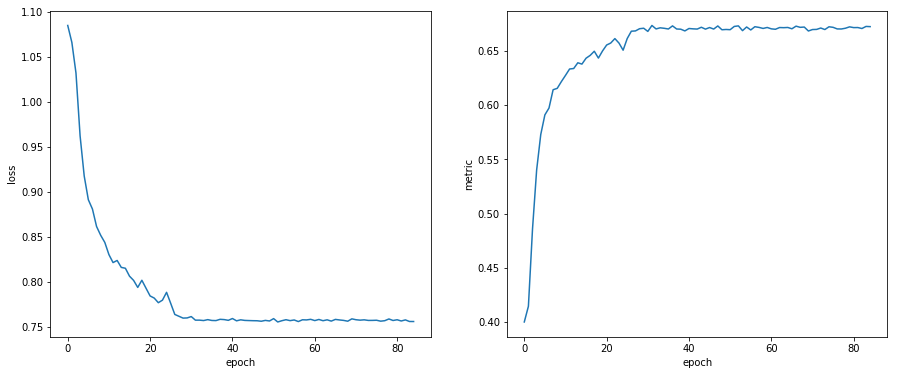

In [68]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range(len(history.epoch)),history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(range(len(history.epoch)),history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('metric')


**Exercice 3**: Regarder les layers disponible pour les problématiques de vision. Puis construire le réseau correspondant à l'image suivante (VGG16).

![](vgg16.png)

In [1]:

def VGG16_model(input_shape=(224, 224, 3)):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))  ## si 1000 class (imgnet)
    return model

# Créer une instance du modèle
vgg16_model = VGG16_model()

# Afficher un résumé du modèle
vgg16_model.summary()


/home/arthur/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)      │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)      │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)     │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)       │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 25088)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 4096)              │ 102,764,5… │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 4096)              │ 16,781,312 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1000)              │  4,097,000 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)